## Mešano celoštevilsko linearno programiranje 
Za iskanje minimuma ter maksimuma **drugega komplementarnega Zagrebškega indeksa** na
povezanih grafih s *n* vozlišči ter $m=n-1+k$ povezavami, kjer je $k$ ciklomatično 
število.

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Model output:
{'objective': 0.0, 'edges': [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)], 'deg': {0: 3, 1: 3, 2: 3, 3: 3}, 's': {0: 9.0, 1: 9.0, 2: 9.0, 3: 9.0}, 'x': {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (1, 2): 1.0, (1, 3): 1.0, (2, 3): 1.0}, 'y': {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 1.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 1.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 1.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 1.0}}


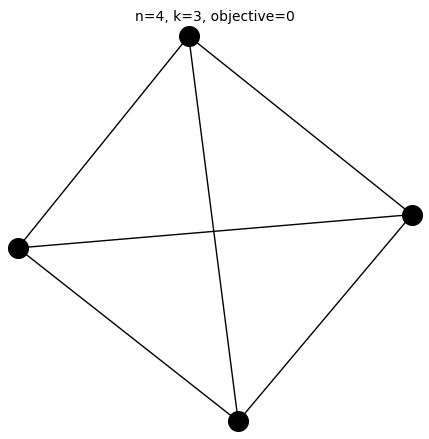

In [49]:
class MILP:
    def __init__(
        self, 
        n : int,
        k : int,
    ):
        self.n = n 
        self.k = k 
        self.m = n - 1 + k
        self.minG = Graph()
        self.maxG = Graph()
        self.min = None 
        self.max = None
        if not self.valid_parameters(n, k):
            raise ValueError("Parameters not valid.")

    @staticmethod
    def valid_parameters(n, k):
        if n < 1 or k < 0 or \
            n + k - 1 > (n * (n - 1)) // 2 or \
            k > (n * (n -1)) // 2 - (n - 1):
            return False 
        return True

    def display(self, _type='min', filename=None, layout='spring'):
        G = self.minG if _type=='min' else self.maxG
        obj = self.min if _type == 'min' else self.max
        fig = G.plot(
            figsize=6,
            layout=layout,
            vertex_color='black',
            edge_color='black',
            vertex_labels=False,
            title=f"n={G.num_verts()}, k={G.num_edges() - G.num_verts() + 1}, objective={obj}"
        )
        if filename: 
            fig.save(filename)
        return fig.show()
    
    def find_min(
        self, 
        solver_name = 'GLPK',
    ) -> None:
        V = list(range(self.n)) # vertices
        E = E = [(u, v) for u in V for v in V if u < v] # edges 
        print(E)
        T = V 
        r = 0

        p = MixedIntegerLinearProgram(maximization=False, solver=solver_name)
        x = p.new_variable(binary=True)
        y = p.new_variable(binary=True)
        s = p.new_variable(nonnegative=True) 
        z = p.new_variable(nonnegative=True)
        f = p.new_variable(nonnegative=True, integer=True) 

        p.add_constraint(sum(x[u, v] for (u, v) in E) == self.m)
        p.add_constraint(sum(f[r, v] for v in V if v != r) == self.n - 1)
        for u in V:
            p.add_constraint(sum(y[u, t] for t in T) == 1)
            p.add_constraint(
                sum(x[min(u, v), max(u, v)] for v in V if v != u)
                == sum(t * y[u, t] for t in T)
            )
            p.add_constraint(s[u] == sum((t*t) * y[u, t] for t in T))
            if u != r: 
                p.add_constraint(
                    sum(f[v, u] for v in V if u != v) - 
                    sum(f[u,v] for v in V if v != u) == 1
                )
            for v in V:
                if u == v: continue
                i,j = (u,v) if u < v else (v,u)
                p.add_constraint(f[u,v] <= (self.n-1) * x[i,j])
        for (i,j) in E:
            p.add_constraint(z[i,j] >= s[i] - s[j] - (self.n - 1)**2 * (1- x[i,j]))
            p.add_constraint(z[i,j] >= s[j] - s[i] - (self.n - 1)**2 * (1- x[i,j]))

        p.set_objective(sum(z[i,j] for (i,j) in E))

        try: p.solve() 
        except Exception as e: 
            print("No solution.")
            return 

        obj = p.get_objective_value()
        xvals = p.get_values(x)
        yvals = p.get_values(y)
        sval = p.get_values(s)
        edges = [e for e,v in xvals.items() if v > 0.5]
        deg = {}
        for i in V:
            for t in T:
                if yvals.get((i,t),0) > 0.5:
                    deg[i] = t
                    break
        print(
            "Model output:\n"
            f"""{dict( 
                objective=obj, 
                edges=edges,
                deg=deg,
                s=sval,
                x=xvals,
                y=yvals,
            )}"""
        )
        self.minG = Graph()
        for (u, v) in edges: 
            self.minG.add_edge(u, v) 
        self.min = int(round(obj))
        

milp = MILP(4, 3)
milp.find_min()
milp.display('min')
